In [ ]:
# standard libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.simplefilter('ignore')

# sklearn libraries
from sklearn.cluster import *
from sklearn.metrics import *

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
# utility function to calculate bayesian estimate
def get_bayesian_est(row):
    '''
    formula = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

    where:

    R = average for the movie (mean) = (Rating)
    v = number of votes for the movie = (votes)
    m = minimum votes required to be listed
    C = the mean vote across the whole report

    '''
    m = df.total_ratings.min()  #minimum total_ratings
    C = round(df.total_ratings.mean(),2)
    R = row['avg_ratings']
    v = row['total_ratings']

    if not m or not C:
        raise TypeError("Bayesian mean must be computed with m and C")

    wr = (v / (v + m)) * R + (m / (v + m)) * C

    return round(wr,1)

# Load Data

In [ ]:
# load
CSV = '/content/swiggy.csv'
df = pd.read_csv(CSV)


# change column names
df.columns = ['_'.join(c.split(' ')).lower() for c in df.columns]


# filtering the data
city = 'Pune'
df = df[df['city'] == city]


# filter on columns
wanted_cols = ['area', 'restaurant', 'price', 'avg_ratings', 'total_ratings', 'food_type', 'delivery_time']
df = df[wanted_cols]


# filter on food type count
df['food_type_count'] = df['food_type'].apply(lambda x:  len(x.split(',')))
q = 0.50  # 50th percentile
n = np.quantile(df['food_type_count'], q)
df = df[df['food_type_count'] <= n]


# split food type into seperate columns
df[['food_type_1', 'food_type_2']] = df['food_type'].str.split(',', 1, expand=True)


# calculate the bayesian estimates
df['weighted_ratings'] = df.apply(get_bayesian_est, axis=1)


# drop unwanted columns
unwanted = ['food_type_count', 'food_type', 'avg_ratings', 'total_ratings']
df.drop(unwanted, axis=1, inplace=True)

# drop index
idx = 2206 # this data point has invalid food_type
df.drop(idx,axis=0, inplace=True)


# drop NULLs & reset index
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


# view
df.head()

,area,restaurant,price,delivery_time,food_type_1,food_type_2,weighted_ratings
0,Aundh,Cafe Peterdonuts,400.0,71,Continental,Desserts,26.0
1,Kothrud,Zest Cafe Bar,250.0,57,Chinese,Fast Food,42.5
2,Kothrud,Rushhrs,250.0,46,Salads,Healthy Food,17.0
3,Fc Road,The Burger Barn Cafe,300.0,46,American,Fast Food,16.9
4,Koregaon Park,Arthur'S Theme,800.0,56,Italian,European,17.0


In [ ]:
# create a map & inverse-map for area
area_map = dict( enumerate(df.area.unique().tolist(), start=1) )
inv_area_map = {v: k for k, v in area_map.items()}


# create a map & inverse-map for food_type(s)
combined_food_type = list(set((df['food_type_1'].to_list()) + list(df['food_type_2'].to_list())))
food_type_map = dict( enumerate(combined_food_type, start=1) )
inv_food_type_map = {v: k for k, v in food_type_map.items()}


# convert categorical columns to numerical
#df['area'] = df['area'].apply(lambda x: inv_area_map[x])
#df['food_type_1'] = df['food_type_1'].apply(lambda x: inv_food_type_map[x])
#df['food_type_2'] = df['food_type_2'].apply(lambda x: inv_food_type_map[x])


# view
#df.head()

# Calculate Silhouette Score

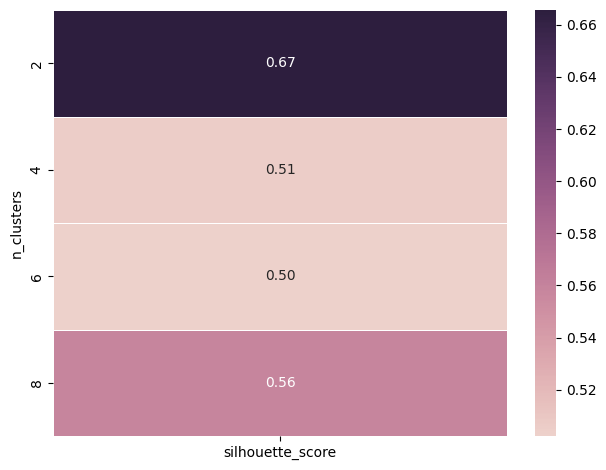

In [ ]:
# select numerical columns
numerics = ['int64', 'float64']
num_cols = df.select_dtypes(include=numerics).columns.tolist()

# filtering the dataframe on numeric columns only
df_num = df.loc[:,num_cols]


# Silhouette-Score method to find ‘n’ number of clusters for clustering
'''
  The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
  The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
  If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value,
  then the clustering configuration may have too many or too few clusters.
'''

cluster_range = np.linspace(2, 8, num= 4, endpoint=True, retstep=False, dtype=np.int64)
results = []

for c in cluster_range:
    clusterer = KMeans(n_clusters=c, n_init='auto', algorithm='elkan', random_state = np.random.randint(1,10))
    cluster_labels = clusterer.fit_predict(df_num)
    sil_avg = silhouette_score(df_num, cluster_labels)
    results.append([c, sil_avg])

result = pd.DataFrame(results, columns=['n_clusters', 'silhouette_score'])
pivot_tb = pd.pivot_table(result, index='n_clusters', values='silhouette_score')

# visualise
plt.figure()
sns.heatmap(pivot_tb, annot=True, linewidths=0.5, fmt='.2f', cmap=sns.cubehelix_palette(as_cmap=True))
plt.tight_layout()


**KMeans Cluster**

In [ ]:
# K-Mean Clustering
kmeans = KMeans(n_clusters=2,  # from above
                n_init='auto',
                algorithm='elkan',
                max_iter=500 # changing from default 300 to this value
               )

kmeans_sel = kmeans.fit(df_num)
kmeans_labels = pd.DataFrame(kmeans_sel.labels_)
df_cluster_kmeans = df.assign(Cluster=kmeans_labels)


# grouped k-means
grouped_clus_km = df_cluster_kmeans.groupby(['Cluster']).mean().round(1)
grouped_clus_km

,price,delivery_time,weighted_ratings
Cluster,,,
0,947.6,56.4,24.2
1,301.6,56.7,24.1


# Analysis
* Entire Dataset Averages:

  * price = 349.88
  * delivery time = 56.63
  * weighted ratings = 24.08
* Cluster#1 (0) - Restaurants with above average price (860.7), above average delivery time (57.3) but below average weighted ratings (23.6)
* Cluster#2 (1) - Restaurants with below average price (293.3), average delivery time (56.6) & (slightly) above average weighted ratings (24.1)

In [ ]:
# visualise the data (in tabular format)

# selected columns
sel_cols = df_cluster_kmeans.columns[:-1].to_list()
sample_size = 5

# below average - cluster#1 (0)
temp = df_cluster_kmeans[df_cluster_kmeans['Cluster'] == 0].sample(sample_size)
temp = temp.iloc[:,:-1]


fig = go.Figure(data=[go.Table(header=dict(values=sel_cols,
                                   fill_color='paleturquoise',
                                   align='left'),
                       cells=dict(values=[temp.area, temp.restaurant, temp.price, temp.delivery_time, temp.food_type_1, temp.food_type_2, temp.weighted_ratings],
                                  fill_color='lavender',
                                  align='left')) ])

fig.update_layout(title_text='Cluster#1 (0)', autosize=True)

fig.show()

In [ ]:
# below average - cluster#2 (1)
temp = df_cluster_kmeans[df_cluster_kmeans['Cluster'] == 1].sample(sample_size)
temp = temp.iloc[:,:-1]


fig = go.Figure(data=[go.Table(header=dict(values=sel_cols,
                                   fill_color='paleturquoise',
                                   align='left'),
                       cells=dict(values=[temp.area, temp.restaurant, temp.price, temp.delivery_time, temp.food_type_1, temp.food_type_2, temp.weighted_ratings],
                                  fill_color='lavender',
                                  align='left')) ])

fig.update_layout(title_text='Cluster#2 (1)', autosize=True)

fig.show()

# Bisecting KMeans Cluster

In [ ]:
# K-Mean Clustering
bi_kmeans = BisectingKMeans(n_clusters=2,  # from above
                n_init=10,
                algorithm='elkan',
                max_iter=500,  # changing from default 300 to this value
                bisecting_strategy='biggest_inertia'
               )

kmeans_sel = bi_kmeans.fit(df_num)
kmeans_labels = pd.DataFrame(kmeans_sel.labels_)
df_cluster_bi_kmeans = df.assign(Cluster=kmeans_labels)


# grouped k-means
grouped_clus_bi_km = df_cluster_bi_kmeans.groupby(['Cluster']).mean().round(1)
grouped_clus_bi_km


,price,delivery_time,weighted_ratings
Cluster,,,
0,271.0,55.9,23.8
1,697.1,59.9,25.4


# Analysis
* Entire Dataset Averages:
   * price = 349.88
   * delivery time = 56.63
   * weighted ratings = 24.08
* Cluster#1 (0) - Restaurants with below average price (271.0), below average delivery time (55.9) & below average weighted ratings (23.8)
* Cluster#2 (1) - Restaurants with above average price (697.1), above average delivery time (59.9) & (slightly) above average weighted ratings (25.4)

In [ ]:
# visualise the data (in tabular format)

# selected columns
sel_cols = df_cluster_bi_kmeans.columns[:-1].to_list()
sample_size = 5

# below average - cluster#1 (0)
temp = df_cluster_bi_kmeans[df_cluster_bi_kmeans['Cluster'] == 0].sample(sample_size)
temp = temp.iloc[:,:-1]


fig = go.Figure(data=[go.Table(header=dict(values=sel_cols,
                                   fill_color='paleturquoise',
                                   align='left'),
                       cells=dict(values=[temp.area, temp.restaurant, temp.price, temp.delivery_time, temp.food_type_1, temp.food_type_2, temp.weighted_ratings],
                                  fill_color='lavender',
                                  align='left')) ])

fig.update_layout(title_text='Cluster#1 (0)', autosize=True)
fig.show()

In [ ]:
# visualise the data (in tabular format)

# selected columns
sel_cols = df_cluster_bi_kmeans.columns[:-1].to_list()
sample_size = 5

# below average - cluster#1 (0)
temp = df_cluster_bi_kmeans[df_cluster_bi_kmeans['Cluster'] == 1].sample(sample_size)
temp = temp.iloc[:,:-1]


fig = go.Figure(data=[go.Table(header=dict(values=sel_cols,
                                   fill_color='paleturquoise',
                                   align='left'),
                       cells=dict(values=[temp.area, temp.restaurant, temp.price, temp.delivery_time, temp.food_type_1, temp.food_type_2, temp.weighted_ratings],
                                  fill_color='lavender',
                                  align='left')) ])

fig.update_layout(title_text='Cluster#2 (1)', autosize=True)
fig.show()

# Mini KMeans Cluster

In [ ]:
# K-Mean Clustering
m_kmeans = MiniBatchKMeans(n_clusters=2,  # from above
                n_init='auto',
                max_iter=500,  # changing from default 300 to this value
               )

kmeans_sel = m_kmeans.fit(df_num)
kmeans_labels = pd.DataFrame(kmeans_sel.labels_)
df_cluster_m_kmeans = df.assign(Cluster=kmeans_labels)


# grouped k-means
grouped_clus_m_km = df_cluster_m_kmeans.groupby(['Cluster']).mean().round(1)
grouped_clus_m_km

,price,delivery_time,weighted_ratings
Cluster,,,
0,697.1,59.9,25.4
1,271.0,55.9,23.8


# Analysis
* Entire Dataset Averages:
   * price = 349.88
   * delivery time = 56.63
   * weighted ratings = 24.08
* Cluster#1 (0) - Restaurants with below average price (271.0), below average delivery time (55.9) & below average weighted ratings (23.8)
* Cluster#2 (1) - Restaurants with above average price (697.1), above average delivery time (59.9) & (slightly) above average weighted ratings (25.4)

In [ ]:
# visualise the data (in tabular format)

# selected columns
sel_cols = df_cluster_m_kmeans.columns[:-1].to_list()
sample_size = 5

# below average - cluster#1 (0)
temp = df_cluster_m_kmeans[df_cluster_m_kmeans['Cluster'] == 0].sample(sample_size)
temp = temp.iloc[:,:-1]


fig = go.Figure(data=[go.Table(header=dict(values=sel_cols,
                                   fill_color='paleturquoise',
                                   align='left'),
                       cells=dict(values=[temp.area, temp.restaurant, temp.price, temp.delivery_time, temp.food_type_1, temp.food_type_2, temp.weighted_ratings],
                                  fill_color='lavender',
                                  align='left')) ])

fig.update_layout(title_text='Cluster#1 (0)', autosize=True)
fig.show()

In [ ]:
# visualise the data (in tabular format)

# selected columns
sel_cols = df_cluster_m_kmeans.columns[:-1].to_list()
sample_size = 5

# below average - cluster#1 (0)
temp = df_cluster_m_kmeans[df_cluster_m_kmeans['Cluster'] == 1].sample(sample_size)
temp = temp.iloc[:,:-1]


fig = go.Figure(data=[go.Table(header=dict(values=sel_cols,
                                   fill_color='paleturquoise',
                                   align='left'),
                       cells=dict(values=[temp.area, temp.restaurant, temp.price, temp.delivery_time, temp.food_type_1, temp.food_type_2, temp.weighted_ratings],
                                  fill_color='lavender',
                                  align='left')) ])

fig.update_layout(title_text='Cluster#2 (1)', autosize=True)
fig.show()